In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, BatchNormalization
from keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split

Using TensorFlow backend.
C:\Users\YooSeok\Anaconda3\envs\Keras\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\YooSeok\Anaconda3\envs\Keras\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\YooSeok\Anaconda3\envs\Keras\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\YooSeok\Anaconda3\envs\Keras\lib

In [2]:
df_data = pd.read_csv('data.csv')
print(df_data.shape)

(55277, 2)


In [3]:
df_data.head(10)

,Time,Lux
0,2018-08-10 09:41:37 UTC,527
1,2018-08-10 09:42:26 UTC,942
2,2018-08-10 09:43:16 UTC,942
3,2018-08-10 09:44:04 UTC,942
4,2018-08-10 09:44:53 UTC,942
5,2018-08-10 09:45:41 UTC,941
6,2018-08-10 09:46:31 UTC,951
7,2018-08-10 09:47:19 UTC,951
8,2018-08-10 09:48:08 UTC,951
9,2018-08-10 09:48:57 UTC,951


In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55277 entries, 0 to 55276
Data columns (total 2 columns):
Time    55277 non-null object
Lux     55277 non-null int64
dtypes: int64(1), object(1)
memory usage: 863.8+ KB


In [5]:
df_data['Time'] = pd.to_datetime(df_data['Time'])

In [6]:
hour, minute, second = [], [], []
for i in range(np.size(df_data, 0)):
    hour.append(df_data['Time'][i].hour)
    minute.append(df_data['Time'][i].minute)
    second.append(df_data['Time'][i].second)

In [7]:
hour = np.array(hour).reshape(-1, 1)
minute = np.array(minute).reshape(-1, 1)
second = np.array(second).reshape(-1, 1)

print(hour.shape, minute.shape, second.shape)

(55277, 1) (55277, 1) (55277, 1)


In [8]:
lux = df_data['Lux'].values.reshape(-1, 1)
print(lux.shape)

(55277, 1)


In [9]:
lux = (lux - lux.mean()) / lux.std()

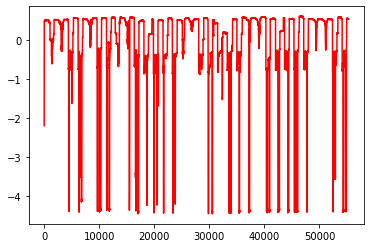

In [10]:
lux
plt.plot(lux[:,0], 'r', label='y_true')
plt.show()

In [11]:
data = np.concatenate((hour, minute, second, lux), axis=1)
print(data.shape)

(55277, 4)


In [12]:
data[:10]

array([[ 9.        , 41.        , 37.        , -2.19270162],
       [ 9.        , 42.        , 26.        ,  0.39705694],
       [ 9.        , 43.        , 16.        ,  0.39705694],
       [ 9.        , 44.        ,  4.        ,  0.39705694],
       [ 9.        , 44.        , 53.        ,  0.39705694],
       [ 9.        , 45.        , 41.        ,  0.39081656],
       [ 9.        , 46.        , 31.        ,  0.45322038],
       [ 9.        , 47.        , 19.        ,  0.45322038],
       [ 9.        , 48.        ,  8.        ,  0.45322038],
       [ 9.        , 48.        , 57.        ,  0.45322038]])

In [13]:
train_data = data[:40000]
train_lux = lux[:40000]
print(train_data.shape, train_lux.shape)

(40000, 4) (40000, 1)


In [14]:
test_data = data[40001:]
test_lux = lux[40001:]
print(test_data.shape, test_lux.shape)

(15276, 4) (15276, 1)


In [94]:
lag=5 # 몇분 후 의 데이터를 input feature로 할지(?)

In [95]:
arrnum = 20
arr = []
for i in range(arrnum):
    arr.append(train_data[i:(i-lag-arrnum),:])

arr = np.array(arr, dtype=np.float32)
print(arr.shape)

(20, 39975, 4)


In [96]:
arr[1]

array([[ 9.        , 42.        , 26.        ,  0.39705694],
       [ 9.        , 43.        , 16.        ,  0.39705694],
       [ 9.        , 44.        ,  4.        ,  0.39705694],
       ...,
       [18.        , 22.        , 28.        ,  0.5967492 ],
       [18.        , 23.        , 16.        ,  0.59050876],
       [18.        , 24.        ,  5.        ,  0.59050876]],
      dtype=float32)

In [97]:
x_train_val = np.concatenate((arr[0], arr[1], arr[2], arr[3], arr[4], arr[5], arr[6], arr[7], arr[8], arr[9], arr[10], arr[11], arr[12], arr[13], arr[14], arr[15], arr[16], arr[17], arr[18], arr[19]), axis=1).reshape(-1, arrnum, 4)
train_mean, train_std = np.mean(x_train_val, axis=0), np.std(x_train_val, axis=0)
train_mean, train_std = np.mean(train_mean, axis=0), np.mean(train_std, axis=0)

In [98]:
x_train_val.shape

(39975, 20, 4)

In [99]:
y_train_val = train_lux[(arrnum+lag):, :].reshape(-1, 1)

In [100]:
y_train_val.shape

(39975, 1)

In [101]:
print(x_train_val.shape, y_train_val.shape)

(39975, 20, 4) (39975, 1)


In [102]:
arr = []
for i in range(arrnum):
    arr.append(test_data[i:(i-lag-arrnum),:])
    
arr = np.array(arr, dtype=np.float32)
print(arr.shape)


(20, 15251, 4)


In [103]:
x_test = np.concatenate((arr[0], arr[1], arr[2], arr[3], arr[4], arr[5], arr[6], arr[7], arr[8], arr[9], arr[10], arr[11], arr[12], arr[13], arr[14], arr[15], arr[16], arr[17], arr[18], arr[19]), axis=1).reshape(-1, arrnum, 4)
y_test = test_lux[(lag+arrnum):, :].reshape(-1, 1)
print(x_test.shape, y_test.shape)

(15251, 20, 4) (15251, 1)


In [104]:
# split into training and validation datasets
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(31980, 20, 4) (31980, 1) (7995, 20, 4) (7995, 1)


In [105]:
h_units = 128
activation_ = 'relu'

def rnn_model():
    model = Sequential()
    model.add(LSTM(units=h_units, return_sequences=True, input_shape=(arrnum, 4)))        
    model.add(LSTM(units=h_units, return_sequences=False))
    model.add(Dense(h_units))
    model.add(Dense(1))
    
    return model

In [106]:
# create a model 
model = rnn_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20, 128)           68096     
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 216,321
Trainable params: 216,321
Non-trainable params: 0
_________________________________________________________________


In [107]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [108]:
# training
batch = 512
tensorBoard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

hist = model.fit(x_train, y_train, epochs=100, batch_size=batch, verbose=True, validation_data=(x_val, y_val), shuffle=True, callbacks=[tensorBoard])

Train on 31980 samples, validate on 7995 samples
Epoch 1/100
31980/31980 [==============================] - 5s 162us/step - loss: 0.3403 - val_loss: 0.1319
Epoch 2/100
31980/31980 [==============================] - 4s 124us/step - loss: 0.1364 - val_loss: 0.0956
Epoch 3/100
31980/31980 [==============================] - 4s 125us/step - loss: 0.1168 - val_loss: 0.1012
Epoch 4/100
31980/31980 [==============================] - 4s 126us/step - loss: 0.1104 - val_loss: 0.0838
Epoch 5/100
31980/31980 [==============================] - 4s 125us/step - loss: 0.1037 - val_loss: 0.0837
Epoch 6/100
31980/31980 [==============================] - 4s 124us/step - loss: 0.1015 - val_loss: 0.0741
Epoch 7/100
31980/31980 [==============================] - 4s 125us/step - loss: 0.1029 - val_loss: 0.0829
Epoch 8/100
31980/31980 [==============================] - 4s 124us/step - loss: 0.0996 - val_loss: 0.0748
Epoch 9/100
31980/31980 [==============================] - 4s 129us/step - loss: 0.0977 - val_l

In [109]:
y_pred = model.predict(x_test, batch_size=batch, verbose=True) 
print(y_pred.shape)
print(model.evaluate(x_test, y_test,batch_size=batch))

15251/15251 [==============================] - 1s 72us/step
(15251, 1)
15251/15251 [==============================] - 1s 54us/step
0.2587117524046624


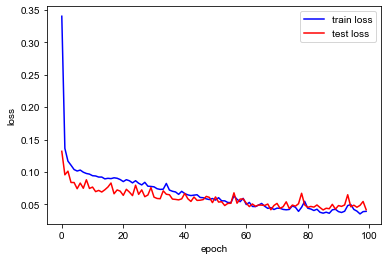

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'b', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='test loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper right')

plt.show()

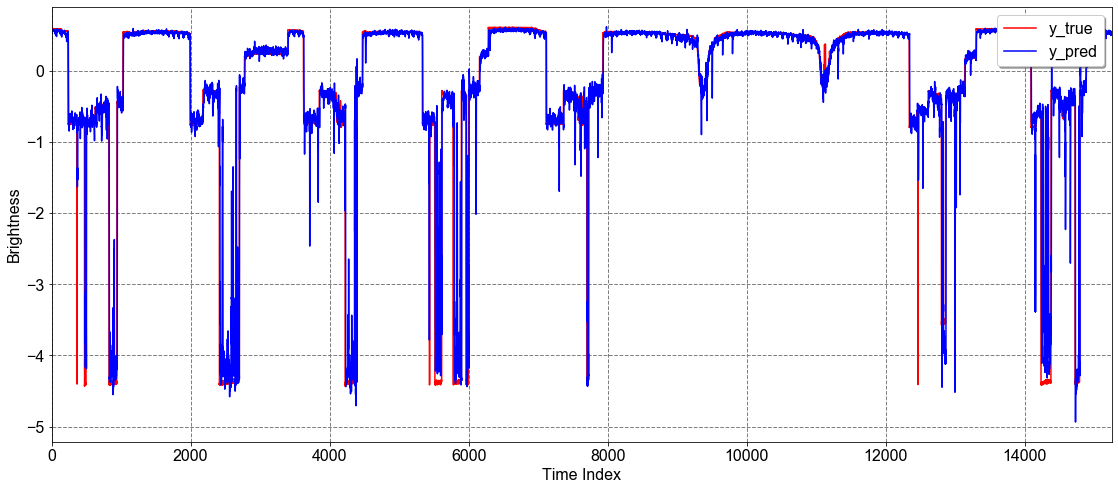

In [111]:
# visualization for prediction result
# set figure size
plt.figure(figsize=(19,8))

# set font
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)

# plot data 
plt.plot(y_test[:,0], 'r', label='y_true')
plt.plot(y_pred[:,0], 'b', label='y_pred')

# set legend position
plt.legend(shadow=True, loc='upper right')

# set x-axis & y-axis titles
#plt.title('prediction result')
plt.xlabel('Time Index')
plt.ylabel('Brightness')

# set axis-limits
plt.xlim(left = 0, right = len(y_test)) 
#plt.ylim(bottom = -5) 

# set grid
plt.grid(color='gray', linestyle='--', linewidth=1)

plt.xticks(np.arange(0,16000,2000))
#plt.yticks(np.arange(0,1,1))

# save & display figure
plt.savefig('pred_graph.png', dpi=300)
plt.show()

In [112]:
#모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
#valScore = model.evaluate(x_val, y_val, verbose=0)
#print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: ', testScore)

Train Score:  0.0371492512891648
Test Score:  0.25871174831530985


In [113]:
#MAPE

y_test, y_pred = np.array(y_test), np.array(y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('MAPE: ', mape)

MAPE:  20.878818891177982


In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))